# CH4-AIR Notebook 
This notebook contains all the methods and the 2 experiments

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge, LinearRegression
from sklearn import gaussian_process
from sklearn.gaussian_process import GaussianProcessRegressor
import scipy.optimize
from sklearn.utils.optimize import _check_optimize_result
from sklearn.gaussian_process.kernels import Matern, RBF, WhiteKernel, RationalQuadratic, ExpSineSquared
import time
from sklearn.decomposition import PCA, SparsePCA
%matplotlib inline
import seaborn as sns
from sklearn.utils import shuffle
# demonstrate data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# Load and prepare data

In [2]:
#read the data into a dataframe
df = pd.read_csv('NewData_flames_data_with_L1_L2_errors_CH4-AIR_with_trimming.txt')



#create an integer representation of the flame-id and add to the data frame
df['flame_key_int'] = df[' flame_key'].mul(10000000).astype(int)

#create an integer to determine if the flame is included by the framework in the manifold creation and reverselookup
#framework_untrimmed_flameids = [0.00115982, 0.00122087, 0.00128512, 0.00135276, 0.00142396, 0.0014989, 0.00157779, 0.00166083, 0.00174825, 0.00184026, 0.00193711, 0.00203907, 0.00214639, 0.00225936, 0.00237827, 0.01]

framework_untrimmed_flameids = ['2.0276547153583627E-4', '2.1343733845877503E-4', '2.2467088258818426E-4', '2.3649566588229923E-4', '2.4894280619189394E-4', '2.6204505914936203E-4', '2.7583690436774953E-4', '2.903546361765785E-4', '3.056364591332405E-4', '3.2172258856130585E-4', '3.3865535638032194E-4', '0.0032353354497370902']


framework_untrimmed_flame_key_ints = [int(float(framework_untrimmed_flameids[i])*10000000) for i in range(len(framework_untrimmed_flameids))]

def isFlame_included(flame_key_int):
    if flame_key_int in framework_untrimmed_flame_key_ints:
        ret_val = 1
    else:
        ret_val = 0
    return ret_val

df['is_flame_included_by_framework'] = df['flame_key_int'].map(lambda x: isFlame_included(x))

df['souener_deciles'] = pd.qcut(df['souener'],10)


### Create PCAs using all the data and add to DF


In [3]:
num_principal_components = 5

pca = PCA(n_components=num_principal_components)

icovariates = []
for c in df.columns:
    if c[0:2] == 'Yi':
        icovariates.append(c)

X = df[icovariates].values
        
pure_pca_dim_cols = ["PURE_PCA_"+str(i+1) for i in range(num_principal_components)]

pca.fit_transform(X)
        
df_pure_pca = pd.DataFrame(pca.transform(X), columns = pure_pca_dim_cols)
        
df = pd.concat([df,df_pure_pca], axis=1)


### Create Sparse PCA

In [4]:
sparsepca = SparsePCA(n_components=num_principal_components)
      
sparse_pca_dim_cols = ["SPARSE_PCA_"+str(i+1) for i in range(num_principal_components)]

sparsepca.fit_transform(X)
        
df_sparse_pca = pd.DataFrame(sparsepca.transform(X), columns = sparse_pca_dim_cols)
        
df = pd.concat([df,df_sparse_pca], axis=1)

### Create PCAs orthogonal to Zmix and add to DF

In [5]:
zmix_pca_dim_cols = ["Zmix_PCA_"+str(i+1) for i in range(num_principal_components)]

#these are the weights calculated on the basis of molar weight of Hydrogen
wopt = np.array([0.25131806468584, 1.0, 0.0, 0.0, 0.05926499970012948, 0.11189834407236524, 0.03053739933116691, 0.05926499970012948, 0.0, 0.07742283372149472, 0.14371856860332313, 0.14371856860332313, 0.20112514400193687, 1.0, 0.0, 0.0, 0.03473494419333629, 0.06713785861443991, 0.09743596683886535, 0.09743596683886535, 0.12582790137651187, 0.04027033873046593, 0.07742283372149472, 0.11180607885607882, 0.14371856860332313, 0.17341738612784788, 0.20112514400193687, 0.024566681794273966, 0.04795526192839207, 0.04795526192839207, 0.0, 0.06713048065088474, 0.12581494366075874, 0.17755300484072126, 0.034730994502665966, 0.0, 0.0, 0.0, 0.03249947443158002, 0.0, 0.0372961080230628, 0.07191024382448291, 0.024564706019978535, 0.023426986426879046, 0.023426986426879046, 0.023426986426879046, 0.0, 0.16374935944566987, 0.18286442054789118, 0.07024850027715426, 0.09152158240065958, 0.0, 0.0] , dtype=float)

'''
Zmix = wopt * Xi --> Zmix += mixFracMassCoeff[s] * Yi[s] in the following code and then it is normalized
Z_f = 0.25131806468584
Z_ox = 0.0
(Zmix - Z_ox) / (Z_f - Z_ox)

public double calc(double[] Yi) {
		double Zmix = 0.;
		for (int s = 0; s < species.length; s++) {
			Zmix += mixFracMassCoeff[s] * Yi[s];
		}
		return (Zmix - Z_ox) / (Z_f - Z_ox);
	}
'''

w = wopt[:,np.newaxis]

# center the data
Xcenter = X - np.mean(X)

A = np.cov(X.T)

# calculate A - ww^TA
L = A - np.dot(np.dot(w,w.T),A)

# get the first eigen vector
values,vectors = np.linalg.eig(L)

vectors = np.real(vectors)

values = np.real(values)

df_zmix_pca = pd.DataFrame()

'''
To reproduce Zmix the actual formula should be 

df_zmix_pca[zmix_pca_dim_cols[0]] = X.dot(wopt)/0.25131806468584

instead of

df_zmix_pca[zmix_pca_dim_cols[0]] = Xcenter.dot(wopt)
'''

df_zmix_pca[zmix_pca_dim_cols[0]] = X.dot(wopt)/0.25131806468584

for i in range(len(zmix_pca_dim_cols)-1):
    df_zmix_pca[zmix_pca_dim_cols[i+1]] = Xcenter.dot(vectors.T[i])
        
df = pd.concat([df,df_zmix_pca], axis=1)

In [6]:
df[sparse_pca_dim_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
SPARSE_PCA_1,16439.0,2.053092e-17,0.286286,-0.750127,-0.195033,0.150253,0.233631,0.233655
SPARSE_PCA_2,16439.0,-1.566833e-17,0.225457,-0.129794,-0.129187,-0.119775,0.014577,0.842079
SPARSE_PCA_3,16439.0,1.685697e-17,0.123741,-0.219599,-0.104966,0.005778,0.099924,0.256044
SPARSE_PCA_4,16439.0,7.023736e-19,0.104072,-0.141973,-0.092128,-0.016216,0.080874,0.231253
SPARSE_PCA_5,16439.0,-1.080575e-19,0.063361,-0.142204,-0.041495,0.009795,0.048431,0.107390


In [7]:
df[pure_pca_dim_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PURE_PCA_1,16439.0,-1.231855e-17,0.325106,-0.490897,-0.237622,-0.114789,0.235187,0.791945
PURE_PCA_2,16439.0,-2.506933e-17,0.238645,-0.317749,-0.189767,-0.045990,0.133304,0.784339
PURE_PCA_3,16439.0,5.024673e-18,0.060421,-0.151624,-0.025273,0.003243,0.035351,0.181623
PURE_PCA_4,16439.0,-1.104212e-17,0.017965,-0.041385,-0.011442,-0.001985,0.007269,0.058252
PURE_PCA_5,16439.0,-2.417786e-18,0.012196,-0.026776,-0.008929,-0.000455,0.008275,0.028624


In [8]:
df[zmix_pca_dim_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Zmix_PCA_1,16439.0,0.430011,0.260305,0.004543,0.212671,0.396430,0.631240,0.995403
Zmix_PCA_2,16439.0,0.072002,0.309451,-0.387347,-0.153352,-0.041850,0.294727,0.831019
Zmix_PCA_3,16439.0,0.047210,0.238312,-0.740447,-0.083354,0.093506,0.235925,0.362873
Zmix_PCA_4,16439.0,0.077555,0.059722,-0.072789,0.052942,0.080633,0.112486,0.256762
Zmix_PCA_5,16439.0,-0.081254,0.017963,-0.139508,-0.088494,-0.079298,-0.069824,-0.039882


In [9]:
df[['Zmix']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Zmix,16439.0,0.430011,0.260305,0.004543,0.212671,0.39643,0.63124,0.995403


In [10]:
#Comparing the 'X' matrix column arrangement for the Constrained PCA formulation
#icovariates
#[CH4, H, O, O2, OH, H2O, HO2, H2O2, C, CH, CH2, CH2(S), CH3, H2, CO, CO2, HCO, CH2O, CH2OH, CH3O, CH3OH, C2H, C2H2, C2H3, C2H4, C2H5, C2H6, HCCO, CH2CO, HCCOH, N, NH, NH2, NH3, NNH, NO, NO2, N2O, HNO, CN, HCN, H2CN, HCNN, HCNO, HOCN, HNCO, NCO, C3H7, C3H8, CH2CHO, CH3CHO, N2, AR]
#df.head()['Zmix']
#X[3].dot(wopt)/0.25131806468584
#Zmix matches with the calculation

In [11]:
'''
import pandas as pd
import numpy as np
import sklearn

dates=['April-10', 'April-11', 'April-12', 'April-13']
fruits=['Apple', 'Papaya', 'Banana', 'Mango']
prices=[3, 1, 2, 4]



tdf = pd.DataFrame({'Date':dates ,
                   'Fruit':fruits ,
                   'Price': prices})

print('Before')
print(tdf)

tdf_shuffled=sklearn.utils.shuffle(tdf,random_state=0)
print(tdf_shuffled)
print('After')
print(tdf)

'''

"\nimport pandas as pd\nimport numpy as np\nimport sklearn\n\ndates=['April-10', 'April-11', 'April-12', 'April-13']\nfruits=['Apple', 'Papaya', 'Banana', 'Mango']\nprices=[3, 1, 2, 4]\n\n\n\ntdf = pd.DataFrame({'Date':dates ,\n                   'Fruit':fruits ,\n                   'Price': prices})\n\nprint('Before')\nprint(tdf)\n\ntdf_shuffled=sklearn.utils.shuffle(tdf,random_state=0)\nprint(tdf_shuffled)\nprint('After')\nprint(tdf)\n\n"

In [12]:
framework_included_flames_int = df[df['is_flame_included_by_framework'] == 1]['flame_key_int'].unique()

framework_excluded_flames_int = df[df['is_flame_included_by_framework'] == 0]['flame_key_int'].unique()

all_flames_int = df['flame_key_int'].unique()


In [13]:
class DataManager:
    def __init__(self, df_totalData):
        self.df = df_totalData
        self.outputScaler = None
        self.inputScaler = None
        self.zmixScaler = None
        self.df_training = None
        self.df_testing = None
        self.X_train = None
        self.X_test = None
        self.X_scaled_train = None
        self.X_scaled_test = None
        self.rom_train = None
        self.rom_test = None
        self.rom_scaled_train = None
        self.rom_scaled_test = None
        self.zmix_train = None
        self.zmix_test = None
        self.zmix_scaled_train = None
        self.zmix_scaled_test = None
        self.Y_train = None
        self.Y_test = None
        self.Y_scaled_train = None
        self.Y_scaled_test = None
        
        return

    def _createTrainTestDfs(self,method):

        if(method == "randomequaltraintestsplit"):
            df_shuffled= shuffle(self.df, random_state=0)
            self.df_training = df_shuffled[::2]
            self.df_testing = df_shuffled[1::2]

        else:
            training_flames_int = []


            testing_flames_int = []

            if(method == "frameworkincludedexcludedequalsplit"):

                for x in framework_included_flames_int:
                    training_flames_int.append(x)

                for x in framework_excluded_flames_int[::2]:
                    training_flames_int.append(x)

                for x in framework_included_flames_int:
                    testing_flames_int.append(x)

                for x in framework_excluded_flames_int[1::2]:
                    testing_flames_int.append(x)

            elif(method == "frameworkincludedtrainexcludedtest"):
                for x in framework_included_flames_int:
                    training_flames_int.append(x)

                for x in framework_excluded_flames_int:
                    testing_flames_int.append(x)

            elif(method == "frameworkincludedtrainexcludedandincludedtest"):
                for x in framework_included_flames_int:
                    training_flames_int.append(x)

                for x in framework_included_flames_int:
                    testing_flames_int.append(x)

                for x in framework_excluded_flames_int:
                    testing_flames_int.append(x)

            else:
                for x in all_flames_int:
                    training_flames_int.append(x)
                    testing_flames_int.append(x)

            self.df_training = self.df[self.df['flame_key_int'].isin(training_flames_int)]

            self.df_testing = self.df[self.df['flame_key_int'].isin(testing_flames_int)]

        return


    def _createTrainTestData(self,method,numCpvComponents):

        method_parts = method.split('_')

        self._createTrainTestDfs(method_parts[1])

        input_data_cols = []
        
        rom_cols = []
        
        output_data_cols = ["souener"]        

        if method_parts[0] == "ZmixCpv":
            input_data_cols = ["Zmix","Cpv"]
        elif method_parts[0] == "ZmixPCA":
            input_data_cols = zmix_pca_dim_cols[0:numCpvComponents] 
        elif method_parts[0] == "SparsePCA":
            input_data_cols = sparse_pca_dim_cols[0:numCpvComponents]
        elif method_parts[0] == "PurePCA":
            input_data_cols = pure_pca_dim_cols[0:numCpvComponents]
        elif method_parts[0] == "ZmixAndSparsePCA":
            input_data_cols = ['Zmix'] + sparse_pca_dim_cols[0:numCpvComponents]
        elif method_parts[0] == "ZmixAndPurePCA":
            input_data_cols = ['Zmix'] + pure_pca_dim_cols[0:numCpvComponents]    
        elif method_parts[0] == "ZmixAllSpecies":    
            input_data_cols = ['Zmix'] + icovariates
        elif method_parts[0] == "AllSpeciesZmixCpv":
            input_data_cols = icovariates
            rom_cols = ["Cpv"]
        elif method_parts[0] == "AllSpeciesZmixPCA":
            input_data_cols = icovariates
            rom_cols = zmix_pca_dim_cols[0:numCpvComponents]            
        elif method_parts[0] == "AllSpeciesPurePCA":
            input_data_cols = icovariates
            rom_cols = pure_pca_dim_cols[0:numCpvComponents]
        elif method_parts[0] == "AllSpeciesZmixAndPurePCA":
            input_data_cols = icovariates
            rom_cols = pure_pca_dim_cols[0:numCpvComponents]            
        elif method_parts[0] == "AllSpeciesSparsePCA":
            input_data_cols = icovariates
            rom_cols = sparse_pca_dim_cols[0:numCpvComponents]
        elif method_parts[0] == "AllSpeciesZmixAndSparsePCA":
            input_data_cols = icovariates
            rom_cols = sparse_pca_dim_cols[0:numCpvComponents]             
        else:
            input_data_cols = icovariates

        self.X_train = self.df_training [input_data_cols].values
        self.X_test = self.df_testing [input_data_cols].values
        self.rom_train = self.df_training [rom_cols].values
        self.rom_test = self.df_testing [rom_cols].values
        self.zmix_train = self.df_training ['Zmix'].values
        self.zmix_test = self.df_testing ['Zmix'].values
        self.Y_train = self.df_training [output_data_cols].values
        self.Y_test = self.df_testing [output_data_cols].values
        print("In _createTrainTestData Y_test.shape: " + str(self.Y_test.shape))
        
        return
    
    def _setInputOutputScalers(self, ipscaler, opscaler):
        if ipscaler == "MinMaxScaler":
            self.inputScaler = MinMaxScaler()
            self.zmixScaler = MinMaxScaler()
        elif ipscaler == "QuantileTransformer":
            self.inputScaler = QuantileTransformer()
            self.zmixScaler = QuantileTransformer()
        else:
            self.inputScaler = None
            self.zmixScaler = None
        if opscaler == "MinMaxScaler":
            self.outputScaler = MinMaxScaler()
            self.romScaler = MinMaxScaler()
        elif opscaler == "QuantileTransformer":
            self.outputScaler = QuantileTransformer()
            self.romScaler = QuantileTransformer()
        else:
            self.outputScaler = None
            self.romScaler = None
            
    def createTrainTestData(self,dataSetMethod,numCpvComponents, ipscaler, opscaler):
        self._createTrainTestData(dataSetMethod,numCpvComponents)
        
        self._setInputOutputScalers(ipscaler, opscaler)
        
        if self.inputScaler is not None:
            self.X_scaled_train = self.inputScaler.fit_transform(self.X_train)
            self.X_scaled_test = self.inputScaler.fit_transform(self.X_test)
            
            self.zmix_scaled_train = self.zmixScaler.fit_transform(self.zmix_train.reshape(self.zmix_train.shape[0], 1))
            self.zmix_scaled_test = self.zmixScaler.fit_transform(self.zmix_test.reshape(self.zmix_test.shape[0], 1))
            self.zmix_train = self.zmix_train.flatten()
            self.zmix_scaled_train = self.zmix_scaled_train.flatten()
            self.zmix_test = self.zmix_test.flatten()
            self.zmix_scaled_test = self.zmix_scaled_test.flatten()
            
        else:
            self.X_scaled_train = None
            self.X_scaled_test = None
            self.zmix_scaled_train = None
            self.zmix_scaled_test = None
            
            
        if self.outputScaler is not None:
            self.Y_scaled_train = self.outputScaler.fit_transform(self.Y_train.reshape(self.Y_train.shape[0], 1))
            self.Y_scaled_test = self.outputScaler.fit_transform(self.Y_test.reshape(self.Y_test.shape[0], 1))
            self.Y_train = self.Y_train.flatten()
            self.Y_scaled_train = self.Y_scaled_train.flatten()
            self.Y_test = self.Y_test.flatten()
            self.Y_scaled_test = self.Y_scaled_test.flatten()
            if not self.rom_train.shape[1] == 0:
                self.rom_scaled_train = self.romScaler.fit_transform(self.rom_train)
                self.rom_scaled_test = self.romScaler.fit_transform(self.rom_test)
        else:
            self.Y_scaled_train = None
            self.Y_scaled_test = None
            self.rom_scaled_train = None
            self.rom_scaled_test = None
        print("In createTrainTestData Y_test.shape: " + str(self.Y_test.shape))

In [14]:
dm = DataManager(df)

## Gaussian Process Ablation Study

In [15]:
class CustomGPR(GaussianProcessRegressor):
    def __init__(self, *args, max_iter=150,max_fun=50, gtol=1e-05, **kwargs):
        super().__init__(*args, **kwargs)
        self._max_iter = max_iter
        self._gtol = gtol
        self._max_fun = max_fun

    #ftol = 1000000000000.0 (factr) * np.finfo(float).eps --> 0.0002220446049250313
    #,'ftol':0.0000002220446049250313
    def _constrained_optimization(self, obj_func, initial_theta, bounds):
        if self.optimizer == "fmin_l_bfgs_b":
            opt_res = scipy.optimize.minimize(obj_func, initial_theta, method="L-BFGS-B", jac=True, bounds=bounds, options={'maxiter':self._max_iter,'maxfun':self._max_fun,'gtol': self._gtol})
            _check_optimize_result("lbfgs", opt_res)
            theta_opt, func_min = opt_res.x, opt_res.fun
        elif callable(self.optimizer):
            theta_opt, func_min = self.optimizer(obj_func, initial_theta, bounds=bounds)
        else:
            raise ValueError("Unknown optimizer %s." % self.optimizer)
        return theta_opt, func_min



def getGPModel(kernel="Matern"):
    if kernel == "Matern_RationalQuadratic":

        # medium term irregularities
        k1 = 0.5* Matern(length_scale=2, nu=3/2)
        k2 = 0.5* RationalQuadratic(length_scale=1.0, alpha=1.0)

        '''
        k4 = 0.1**2 * RBF(length_scale=0.1) \+ WhiteKernel(noise_level=0.1**2,
                      noise_level_bounds=(1e-3, np.inf))  # noise terms
        '''
        kernel = k1 + k2

    elif kernel == "RationalQuadratic":

        # medium term irregularities
        kernel = RationalQuadratic(length_scale=1.0, alpha=1.0)    

    else:
        kernel = Matern(length_scale=2, nu=3/2)

    return CustomGPR(kernel=kernel) 


In [16]:
'''

experimentTrackingFields = ['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime']

df_experimentTracker = pd.DataFrame(columns=experimentTrackingFields)
'''

'\n\nexperimentTrackingFields = [\'Model\',\'Dataset\',\'Cpv Type\',\'#Cpv\',"ZmixExists",\'MAE\',\'TAE\',\'MSE\',\'TSE\',\'#Pts\',\'FitTime\',\'PredTime\']\n\ndf_experimentTracker = pd.DataFrame(columns=experimentTrackingFields)\n'

In [17]:
'''
import os#must import this library

if os.path.exists('results.csv'):
        os.remove('results.csv') #this deletes the file
else:
        print("The results.csv file does not exist")

resultsFile = open('results.csv', 'w')

printStr = "\t"

printStr = printStr.join(experimentTrackingFields)


resultsFile.write(printStr)

resultsFile.write("\n")
'''

'\nimport os#must import this library\n\nif os.path.exists(\'results.csv\'):\n        os.remove(\'results.csv\') #this deletes the file\nelse:\n        print("The results.csv file does not exist")\n\nresultsFile = open(\'results.csv\', \'w\')\n\nprintStr = "\t"\n\nprintStr = printStr.join(experimentTrackingFields)\n\n\nresultsFile.write(printStr)\n\nresultsFile.write("\n")\n'

In [18]:
class ExperimentExecutor:
    def __init__(self):
        self.dm = None
        self.modelType = None
        self.model = None
        self.df_experimentTracker = None
        self.fit_time = None
        self.pred_time = None
        self.err = None
     
    def setModel(self,model):
        self.model = model

    def executeExperiment(self,dataManager, modelType, dataType="randomequaltraintestsplit",inputType="ZmixPCA",noOfCpv=5):
        self.dm = dataManager
        
        self.modelType = modelType
        
        dataSetMethod = inputType + '_' + dataType
        
        self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, None)
        
        self.fitModelAndCalcErr(self.dm.X_train, self.dm.Y_train, self.dm.X_test, self.dm.Y_test)
        
        if inputType.find('Zmix') != -1:
            ZmixPresent = 'Y'
        else:
            ZmixPresent = 'N'

        experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.err[2]),str(self.err[0]),str(self.err[3]),str(self.err[1]),str(self.err[5]),str(self.fit_time),str(self.pred_time)]

        printStr = "self.modelType: "+ self.modelType+ " dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.err[2])

        print(printStr)
        
    def executeExperiments(self,dataManager, modelType, df_experimentTracker):
        self.dm = dataManager
        self.modelType = modelType
        self.df_experimentTracker = df_experimentTracker
        
        #Experiments  
        
        dataTypes = ["randomequaltraintestsplit","frameworkincludedtrainexcludedtest"]
        #dataTypes = ["frameworkincludedtrainexcludedtest"]
        
        #inputTypes = ["ZmixCpv","ZmixPCA","SparsePCA","PurePCA","ZmixAndPurePCA","ZmixAndSparsePCA","ZmixAllSpecies","AllSpecies"]
        inputTypes = ["ZmixAndPurePCA","ZmixAndSparsePCA"]
        #inputTypes = ["ZmixCpv"]
        
        for dataType in dataTypes:
            
            for inputType in inputTypes:
                #ZmixCpv_randomequaltraintestsplit
                dataSetMethod = inputType + '_' + dataType
                        
                if inputType.find('Zmix') != -1:
                    ZmixPresent = 'Y'
                else:
                    ZmixPresent = 'N'
                    
                if inputType.find('PCA') != -1:
                    
                    noOfCpvs = [item for item in range(1, 6)]
                    
                    for noOfCpv in noOfCpvs:
                        #                           dataSetMethod,noOfCpvs, ipscaler, opscaler
                        self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, None)
                        
                        self.fitModelAndCalcErr(self.dm.X_train, self.dm.Y_train, self.dm.X_test, self.dm.Y_test)
                                                
                        experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.err[2]),str(self.err[0]),str(self.err[3]),str(self.err[1]),str(self.err[5]),str(self.fit_time),str(self.pred_time)]

                        self.df_experimentTracker.loc[len(self.df_experimentTracker)] = experimentResults        

                        printStr = "self.modelType: "+ self.modelType+ " dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.err[2])

                        print(printStr)

                        printStr = "\t"

                        printStr = printStr.join(experimentResults)

                        resultsFile.write(printStr)

                        resultsFile.write("\n")
                        
                        
                else:
                   
                    if inputType.find('ZmixCpv') != -1:
                        noOfCpv = 1
                    else:
                        noOfCpv = 53
                        
                    #                           dataSetMethod,noOfCpvs, ipscaler, opscaler
                    self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, None)

                    self.fitModelAndCalcErr(self.dm.X_train, self.dm.Y_train, self.dm.X_test, self.dm.Y_test)    

                    experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.err[2]),str(self.err[0]),str(self.err[3]),str(self.err[1]),str(self.err[5]),str(self.fit_time),str(self.pred_time)]
                        
                    self.df_experimentTracker.loc[len(self.df_experimentTracker)] = experimentResults        

                    printStr = "self.modelType: "+ self.modelType+ " dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.err[2])

                    print(printStr)

                    printStr = "\t"

                    printStr = printStr.join(experimentResults)

                    resultsFile.write(printStr)

                    resultsFile.write("\n")
        
    def computeError (self,Y_pred, Y_test):
        evaluation_df_1 = pd.DataFrame()

        evaluation_df_1['souener'] = Y_test.flatten()

        evaluation_df_1['souener_pred'] = Y_pred.flatten()

        evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

        evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']

        evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 

        TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

        TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()

        MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

        MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()

        NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()

        MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints

        return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

            
    def printError (self,err):
        TotalAbsoluteError = err[0]

        TotalSquaredError = err[1]

        MeanAbsoluteError = err[2]

        MeanSquaredError = err[3]

        MeanPercentageError = err[4]

        NumPoints = err[5]
        
        print ('Total Absolute Error: ', TotalAbsoluteError)
        print ('Mean Absolute Error: ', MeanAbsoluteError)
        print ('Mean Percentage Error: ', MeanPercentageError)
        print ('Total Squared Error: ', TotalSquaredError)
        print ('Mean Squared Error: ', MeanSquaredError)
        print ('Number of Points: ', NumPoints)

    def computeAndPrintError(self,Y_pred, Y_test):    
        self.err = computeError (Y_pred, Y_test)
        printError (err)
        logError(err)
        return err    
        
        
        
    def fitModelAndCalcErr(self,X_train, Y_train, X_test, Y_test):

        t = time.process_time()

        self.model.fit(X_train, Y_train)

        self.fit_time = time.process_time() - t

        t = time.process_time()

        Y_pred = self.model.predict(X_test, return_std=False)

        self.pred_time = time.process_time() - t
        
        #computeAndPrintError(Y_pred, Y_test)

        self.err = self.computeError (Y_pred, Y_test)
        
        return 

In [19]:
'''
expExectr = ExperimentExecutor()
expExectr.setModel(getGPModel("Matern"))
expExectr.executeExperiment(dm, "GP_Matern", dataType="randomequaltraintestsplit",inputType="ZmixPCA",noOfCpv=5)
'''

'\nexpExectr = ExperimentExecutor()\nexpExectr.setModel(getGPModel("Matern"))\nexpExectr.executeExperiment(dm, "GP_Matern", dataType="randomequaltraintestsplit",inputType="ZmixPCA",noOfCpv=5)\n'

In [20]:
'''
expExectr = ExperimentExecutor()
expExectr.setModel(getGPModel("Matern"))
expExectr.executeExperiments(dm, "GP_Matern", df_experimentTracker)
'''

'\nexpExectr = ExperimentExecutor()\nexpExectr.setModel(getGPModel("Matern"))\nexpExectr.executeExperiments(dm, "GP_Matern", df_experimentTracker)\n'

In [21]:
'''
expExectr = ExperimentExecutor()
expExectr.setModel(getGPModel("Matern_RationalQuadratic"))
expExectr.executeExperiments(dm, "GP_Matern_RationalQuadratic", df_experimentTracker)
'''

'\nexpExectr = ExperimentExecutor()\nexpExectr.setModel(getGPModel("Matern_RationalQuadratic"))\nexpExectr.executeExperiments(dm, "GP_Matern_RationalQuadratic", df_experimentTracker)\n'

In [22]:
'''
expExectr = ExperimentExecutor()
expExectr.setModel(getGPModel("RationalQuadratic"))
expExectr.executeExperiments(dm, "GP_RationalQuadratic", df_experimentTracker)
'''

'\nexpExectr = ExperimentExecutor()\nexpExectr.setModel(getGPModel("RationalQuadratic"))\nexpExectr.executeExperiments(dm, "GP_RationalQuadratic", df_experimentTracker)\n'

In [23]:
#df_experimentTracker

In [24]:
'''
df_experimentTracker.to_csv('PAPER1_PCA_GP_DNN_NEIGHBORDNN_PCDNN_V2_Experiments.csv', sep='\t',encoding='utf-8', index=False)

#!!!!!!! Very Important !!!!!!
resultsFile.close()
'''

"\ndf_experimentTracker.to_csv('PAPER1_PCA_GP_DNN_NEIGHBORDNN_PCDNN_V2_Experiments.csv', sep='\t',encoding='utf-8', index=False)\n\n#!!!!!!! Very Important !!!!!!\nresultsFile.close()\n"

## Simple DNN Ablation Study

In [25]:
def getResiduals(Y_test,Y_pred):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['res'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 
   
    return evaluation_df_1['res'].values


In [26]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [Souener]')
    plt.legend()
    plt.grid(True)
    
   

In [27]:
'''
dnnexperimentTrackingFields = ['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime','MAX-MAE','MAX-TAE','MAX-MSE','MAX-TSE','MIN-MAE','MIN-TAE','MIN-MSE','MIN-TSE']

df_dnnexperimentTracker = pd.DataFrame(columns=dnnexperimentTrackingFields)
'''

'\ndnnexperimentTrackingFields = [\'Model\',\'Dataset\',\'Cpv Type\',\'#Cpv\',"ZmixExists",\'MAE\',\'TAE\',\'MSE\',\'TSE\',\'#Pts\',\'FitTime\',\'PredTime\',\'MAX-MAE\',\'MAX-TAE\',\'MAX-MSE\',\'MAX-TSE\',\'MIN-MAE\',\'MIN-TAE\',\'MIN-MSE\',\'MIN-TSE\']\n\ndf_dnnexperimentTracker = pd.DataFrame(columns=dnnexperimentTrackingFields)\n'

In [28]:
'''
import os#must import this library

if os.path.exists('results.csv'):
        os.remove('results.csv') #this deletes the file
else:
        print("The results.csv file does not exist")

resultsFile = open('results.csv', 'w')

printStr = "\t"

printStr = printStr.join(dnnexperimentTrackingFields)


resultsFile.write(printStr)

resultsFile.write("\n")
'''

'\nimport os#must import this library\n\nif os.path.exists(\'results.csv\'):\n        os.remove(\'results.csv\') #this deletes the file\nelse:\n        print("The results.csv file does not exist")\n\nresultsFile = open(\'results.csv\', \'w\')\n\nprintStr = "\t"\n\nprintStr = printStr.join(dnnexperimentTrackingFields)\n\n\nresultsFile.write(printStr)\n\nresultsFile.write("\n")\n'

In [29]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import EarlyStopping
# patient early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=45)

class DNNExperimentExecutor:
    def __init__(self):
        self.dm = None
        self.modelType = None
        self.model = None
        self.df_experimentTracker = None
        self.fit_time = None
        self.pred_time = None
        self.err = None
        self.df_err = None 
        self.width = 512
        self.halfwidth = 128    
    
    def setModel(self,model):
        self.model = model
        


    def build_and_compile_simple_dnn_model(self,noOfInputNeurons):
        inputs = keras.Input(shape=(noOfInputNeurons,), name="inputs")

        x = layers.Dense(32, activation="relu")(inputs)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(32, activation="relu")(x)

        
        souener_pred = layers.Dense(1, name="prediction")(x)

        model = keras.Model(
            inputs=[inputs],
            outputs=[souener_pred],
        )

        opt = keras.optimizers.Adam(learning_rate=0.001)
        
        model.compile(loss='mean_absolute_error',optimizer=opt)
        
        return model

    def executeExperiment(self,dataManager, modelType, dataType="randomequaltraintestsplit",inputType="ZmixPCA",noOfCpv=5):
        self.dm = dataManager
        
        self.modelType = modelType
        
        dataSetMethod = inputType + '_' + dataType
        
        self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, None)
        
        self.fitModelAndCalcErr(self.dm.X_train, self.dm.Y_train, self.dm.X_test, self.dm.Y_test)
        
        if inputType.find('Zmix') != -1:
            ZmixPresent = 'Y'
        else:
            ZmixPresent = 'N'

                            #['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime','MAX-MAE','MAX-TAE','MAX-MSE','MAX-TSE','MIN-MAE','MIN-TAE','MIN-MSE','MIN-TSE']

        experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.df_err['MAE'].mean()),str(self.df_err['TAE'].mean()),str(self.df_err['MSE'].mean()),str(self.df_err['TSE'].mean()),str(self.df_err['#Pts'].mean()),str(self.fit_time),str(self.pred_time),str(self.df_err['MAE'].max()),str(self.df_err['TAE'].max()),str(self.df_err['MSE'].max()),str(self.df_err['TSE'].max()),str(self.df_err['MAE'].min()),str(self.df_err['TAE'].min()),str(self.df_err['MSE'].min()),str(self.df_err['TSE'].min())]

        printStr = "self.modelType: "+ self.modelType+ " dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.err[2])

        print(printStr)
    
    def executeSingleExperiment(self,noOfInputNeurons,dataSetMethod,dataType,inputType,ZmixPresent,noOfCpv):
        
        print('------------------ ' + 'executeSingleExperiments' + ' ------------------')
        
        #                           dataSetMethod,noOfCpvs, ipscaler, opscaler
        self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, None)
        
        self.model = self.build_and_compile_simple_dnn_model(noOfInputNeurons)
        
        self.model.summary()

        self.fitModelAndCalcErr(self.dm.X_train, self.dm.Y_train, self.dm.X_test, self.dm.Y_test)

         #['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime','MAX-MAE','MAX-TAE','MAX-MSE','MAX-TSE','MIN-MAE','MIN-TAE','MIN-MSE','MIN-TSE']

        experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.df_err['MAE'].mean()),str(self.df_err['TAE'].mean()),str(self.df_err['MSE'].mean()),str(self.df_err['TSE'].mean()),str(self.df_err['#Pts'].mean()),str(self.fit_time),str(self.pred_time),str(self.df_err['MAE'].max()),str(self.df_err['TAE'].max()),str(self.df_err['MSE'].max()),str(self.df_err['TSE'].max()),str(self.df_err['MAE'].min()),str(self.df_err['TAE'].min()),str(self.df_err['MSE'].min()),str(self.df_err['TSE'].min())]

        self.df_experimentTracker.loc[len(self.df_experimentTracker)] = experimentResults        

        printStr = "self.modelType: "+ self.modelType+ " dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.df_err['MAE'].min())

        print(printStr)

        printStr = "\t"

        printStr = printStr.join(experimentResults)

        resultsFile.write(printStr)

        resultsFile.write("\n")

    def executeExperiments(self,dataManager, modelType, df_experimentTracker):
        self.dm = dataManager
        self.modelType = modelType
        self.df_experimentTracker = df_experimentTracker
        
        #Experiments  
        
        dataTypes = ["randomequaltraintestsplit","frameworkincludedtrainexcludedtest"]
        #dataTypes = ["frameworkincludedtrainexcludedtest"]
        #dataTypes = ["randomequaltraintestsplit"]
        
        inputTypes = ["ZmixCpv","ZmixPCA","SparsePCA","PurePCA","ZmixAndPurePCA","ZmixAndSparsePCA","ZmixAllSpecies","AllSpecies"]
        #inputTypes = ["ZmixAndPurePCA","ZmixAndSparsePCA"]
        #inputTypes = ["ZmixCpv"]
        #inputTypes = ["PurePCA"]
        
        for dataType in dataTypes:
            print('=================== ' + dataType + ' ===================')
            
            for inputType in inputTypes:
                
                print('------------------ ' + inputType + ' ------------------')
                    
                #ZmixCpv_randomequaltraintestsplit
                dataSetMethod = inputType + '_' + dataType
                
                noOfNeurons = 0
                #ZmixAnd & ZmixAll
                if inputType.find('ZmixA') != -1:
                    noOfNeurons = noOfNeurons + 1

                if inputType.find('Zmix') != -1:
                    ZmixPresent = 'Y'
                else:
                    ZmixPresent = 'N'
                    
                if inputType.find('PCA') != -1:
                    
                    noOfCpvs = [item for item in range(1, 6)]
                    
                    for noOfCpv in noOfCpvs:
                        noOfNeurons = noOfNeurons + 1                        
                        self.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent,noOfCpv)
                else:

                    if inputType.find('ZmixCpv') != -1:
                        noOfCpv = 1
                        noOfNeurons = 2
                    else:
                        noOfCpv = 53
                        noOfNeurons = noOfNeurons + noOfCpv
                    print('------------------ ' + str(noOfNeurons) + ' ------------------')
                    self.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent,noOfCpv)
        
    def computeError (self,Y_pred, Y_test):
        evaluation_df_1 = pd.DataFrame()

        evaluation_df_1['souener'] = Y_test.flatten()

        evaluation_df_1['souener_pred'] = Y_pred.flatten()

        evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

        evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']

        evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 

        TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

        TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()

        MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

        MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()

        NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()

        MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints

        return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

            
    def printError (self,err):
        TotalAbsoluteError = err[0]

        TotalSquaredError = err[1]

        MeanAbsoluteError = err[2]

        MeanSquaredError = err[3]

        MeanPercentageError = err[4]

        NumPoints = err[5]
        
        print ('Total Absolute Error: ', TotalAbsoluteError)
        print ('Mean Absolute Error: ', MeanAbsoluteError)
        print ('Mean Percentage Error: ', MeanPercentageError)
        print ('Total Squared Error: ', TotalSquaredError)
        print ('Mean Squared Error: ', MeanSquaredError)
        print ('Number of Points: ', NumPoints)

    def computeAndPrintError(self,Y_pred, Y_test):    
        self.err = computeError (Y_pred, Y_test)
        printError (err)
        logError(err)
        return err    
        
        
        
    def fitModelAndCalcErr(self,X_train, Y_train, X_test, Y_test):

        fit_times = []
        
        pred_times = []
        
        errs = []
        
        for itr in range(1,11):
            
            t = time.process_time()

            self.model.fit(X_train, {"prediction":Y_train},validation_split=0.2,verbose=0,epochs=100)

            fit_times.append(time.process_time() - t)
        
            t = time.process_time()

            Y_pred = self.model.predict(X_test)
            
            #sns.residplot(Y_pred.flatten(), getResiduals(Y_test,Y_pred))

            pred_times.append(time.process_time() - t)
            
            errs.append(self.computeError (Y_pred, Y_test))
        
        self.fit_time = sum(fit_times)/len(fit_times)
        
        self.pred_time = sum(pred_times)/len(pred_times)
        
        #computeAndPrintError(Y_pred, Y_test)

        self.df_err = pd.DataFrame(errs, columns = ['TAE', 'TSE', 'MAE', 'MSE', 'MAPE', '#Pts'])
        
        return 

In [30]:
'''
expExectr = DNNExperimentExecutor()

expExectr.executeExperiments(dm, "Simple_DNN", df_dnnexperimentTracker)
'''

'\nexpExectr = DNNExperimentExecutor()\n\nexpExectr.executeExperiments(dm, "Simple_DNN", df_dnnexperimentTracker)\n'

In [31]:
#df_dnnexperimentTracker

In [32]:
'''
df_dnnexperimentTracker.to_csv('PAPER1_PCA_GP_DNN_NEIGHBORDNN_PCDNN_V2_Experiments_SimpleDNN.csv', sep='\t',encoding='utf-8', index=False)

#!!!!!!! Very Important !!!!!!
resultsFile.close()
'''

"\ndf_dnnexperimentTracker.to_csv('PAPER1_PCA_GP_DNN_NEIGHBORDNN_PCDNN_V2_Experiments_SimpleDNN.csv', sep='\t',encoding='utf-8', index=False)\n\n#!!!!!!! Very Important !!!!!!\nresultsFile.close()\n"

## PCDNN Ablation Study

In [33]:
class PCDNNExperimentExecutor:
    def __init__(self):
        self.dm = None
        self.modelType = None
        self.model = None
        self.df_experimentTracker = None
        self.fit_time = None
        self.pred_time = None
        self.err = None
        self.df_err = None 
        self.width = 512
        self.halfwidth = 128 
        self.predicitions = None
    
    def setModel(self,model):
        self.model = model
        
    def getPredicitons(self):
        return self.predicitions

    def build_and_compile_pcdnn_v1_wo_zmix_model(self,noOfInputNeurons,noOfCpv):

        species_inputs = keras.Input(shape=(noOfInputNeurons,), name="species_input")

        linear_reduced_dims = layers.Dense(noOfCpv, name="linear_layer")(species_inputs)

        x = layers.Dense(32, activation="relu")(linear_reduced_dims)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(32, activation="relu")(x)
        #Predict the source energy
        souener_pred = layers.Dense(1, name="prediction")(x)

        physics_pred = layers.Dense(noOfCpv, name="physics")(linear_reduced_dims)
        
        model = keras.Model(inputs=[species_inputs],outputs=[souener_pred,physics_pred])

        opt = keras.optimizers.Adam(learning_rate=0.001)
        
        model.compile(loss={"physics": keras.losses.MeanAbsoluteError(),"prediction": keras.losses.MeanAbsoluteError()},loss_weights=[2.0, 0.2],optimizer=opt)
        
        return model

    def build_and_compile_pcdnn_v1_with_zmix_model(self,noOfInputNeurons,noOfCpv):

        species_inputs = keras.Input(shape=(noOfInputNeurons,), name="species_input")
        
        linear_reduced_dims = layers.Dense(noOfCpv, name="linear_layer")(species_inputs)

        zmix = keras.Input(shape=(1,), name="zmix")
            
        x = layers.concatenate([linear_reduced_dims,zmix])
        x = layers.Dense(32, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(32, activation="relu")(x)
        #Predict the source energy
        souener_pred = layers.Dense(1, name="prediction")(x)

        physics_pred = layers.Dense(noOfCpv, name="physics")(linear_reduced_dims)
        
        model = keras.Model(inputs=[species_inputs,zmix],outputs=[souener_pred,physics_pred])

        opt = keras.optimizers.Adam(learning_rate=0.001)
        
        model.compile(loss={"physics": keras.losses.MeanAbsoluteError(),"prediction": keras.losses.MeanAbsoluteError()},loss_weights=[2.0, 0.2],optimizer=opt)
        
        return model
    
    def executeExperiment(self,dataManager, modelType, dataType="randomequaltraintestsplit",inputType="ZmixPCA",noOfCpv=5):
        self.dm = dataManager
        
        self.modelType = modelType
        
        dataSetMethod = inputType + '_' + dataType
        
        self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, None)
        
        #(self,X_train, Y_train, X_test, Y_test, rom_train = None, rom_test = None, zmix_train = None, zmix_test = None, Y_scaler = None)
        self.fitModelAndCalcErr(self.dm.X_train, self.dm.Y_train, self.dm.X_test, self.dm.Y_test,self.dm.rom_train, self.dm.rom_test, self.dm.zmix_train, self.dm.zmix_test, self.dm.outputScaler)
        
        if inputType.find('Zmix') != -1:
            ZmixPresent = 'Y'
        else:
            ZmixPresent = 'N'

                            #['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime','MAX-MAE','MAX-TAE','MAX-MSE','MAX-TSE','MIN-MAE','MIN-TAE','MIN-MSE','MIN-TSE']

        experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.df_err['MAE'].mean()),str(self.df_err['TAE'].mean()),str(self.df_err['MSE'].mean()),str(self.df_err['TSE'].mean()),str(self.df_err['#Pts'].mean()),str(self.fit_time),str(self.pred_time),str(self.df_err['MAE'].max()),str(self.df_err['TAE'].max()),str(self.df_err['MSE'].max()),str(self.df_err['TSE'].max()),str(self.df_err['MAE'].min()),str(self.df_err['TAE'].min()),str(self.df_err['MSE'].min()),str(self.df_err['TSE'].min())]

        printStr = "self.modelType: "+ self.modelType+ " dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.err[2])

        print(printStr)
    
    def executeSingleExperiment(self,noOfInputNeurons,dataSetMethod,dataType,inputType,ZmixPresent,noOfCpv,concatenateZmix):
        
        
        #                           dataSetMethod,noOfCpvs, ipscaler, opscaler
        self.dm.createTrainTestData(dataSetMethod,noOfCpv, None, "MinMaxScaler")
        
        if concatenateZmix == 'N':
            print("--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------")
            self.model = self.build_and_compile_pcdnn_v1_wo_zmix_model(noOfInputNeurons,noOfCpv)
            
        else:
            self.model = self.build_and_compile_pcdnn_v1_with_zmix_model(noOfInputNeurons,noOfCpv)

        
        self.model.summary()

        #(self,X_train, Y_train, X_test, Y_test, rom_train = None, rom_test = None, zmix_train = None, zmix_test = None, Y_scaler = None)
        if self.dm.inputScaler is not None:
            X_train = self.dm.X_scaled_train
            X_test = self.dm.X_scaled_test
            zmix_train = self.dm.zmix_scaled_train
            zmix_test = self.dm.zmix_scaled_test
        else:
            X_train = self.dm.X_train
            X_test = self.dm.X_test
            zmix_train = self.dm.zmix_train
            zmix_test = self.dm.zmix_test
        
        if self.dm.outputScaler is not None:
            Y_train = self.dm.Y_scaled_train
            Y_test = self.dm.Y_scaled_test
            rom_train = self.dm.rom_scaled_train
            rom_test = self.dm.rom_scaled_test
        else:
            Y_train = self.dm.Y_train
            Y_test = self.dm.Y_test
            rom_train = self.dm.rom_train
            rom_test = self.dm.rom_test
            
        self.fitModelAndCalcErr(X_train, Y_train, X_test, Y_test,rom_train, rom_test, zmix_train, zmix_test, self.dm.outputScaler, concatenateZmix)

        #['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime','MAX-MAE','MAX-TAE','MAX-MSE','MAX-TSE','MIN-MAE','MIN-TAE','MIN-MSE','MIN-TSE']

        experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,str(self.df_err['MAE'].mean()),str(self.df_err['TAE'].mean()),str(self.df_err['MSE'].mean()),str(self.df_err['TSE'].mean()),str(self.df_err['#Pts'].mean()),str(self.fit_time),str(self.pred_time),str(self.df_err['MAE'].max()),str(self.df_err['TAE'].max()),str(self.df_err['MSE'].max()),str(self.df_err['TSE'].max()),str(self.df_err['MAE'].min()),str(self.df_err['TAE'].min()),str(self.df_err['MSE'].min()),str(self.df_err['TSE'].min())]

        self.df_experimentTracker.loc[len(self.df_experimentTracker)] = experimentResults        

        printStr = "self.modelType: "+ self.modelType+ " dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.df_err['MAE'].min())

        print(printStr)

        printStr = "\t"

        printStr = printStr.join(experimentResults)

        resultsFile.write(printStr)

        resultsFile.write("\n")


    def fitModelAndCalcErr(self,X_train, Y_train, X_test, Y_test, rom_train = None, rom_test = None, zmix_train = None, zmix_test = None, Y_scaler = None, concatenateZmix = 'N'):

        fit_times = []
        
        pred_times = []
        
        errs = []
        
        for itr in range(1,11):
            
            t = time.process_time()

            if concatenateZmix == 'Y':
                history = self.model.fit({"species_input":X_train, "zmix":zmix_train}, {"physics":rom_train,"prediction":Y_train},validation_split=0.2,verbose=0,epochs=100)
            else:
                history = self.model.fit({"species_input":X_train}, {"physics":rom_train,"prediction":Y_train},validation_split=0.2,verbose=0,epochs=100)
            
            #self.plot_loss_physics_and_regression(history)
            
            fit_times.append(time.process_time() - t)
        
            t = time.process_time()

            if concatenateZmix == 'Y':
                predictions = self.model.predict({"species_input":X_test, "zmix":zmix_test})
            else:
                predictions = self.model.predict({"species_input":X_test})
                
            pred_times.append(time.process_time() - t)
            
            self.predicitions = predictions
            
            Y_pred = predictions[0]
            

            if Y_scaler is not None:
                Y_pred = Y_scaler.inverse_transform(Y_pred)
                
                
            #sns.residplot(Y_pred.flatten(), getResiduals(Y_test,Y_pred))

            errs.append(self.computeError (Y_pred, Y_test))
        
        self.fit_time = sum(fit_times)/len(fit_times)
        
        self.pred_time = sum(pred_times)/len(pred_times)
        
        #computeAndPrintError(Y_pred, Y_test)

        self.df_err = pd.DataFrame(errs, columns = ['TAE', 'TSE', 'MAE', 'MSE', 'MAPE', '#Pts'])
        
        return  

    def executeExperiments(self,dataManager, modelType, df_experimentTracker):
        self.dm = dataManager
        self.modelType = modelType
        self.df_experimentTracker = df_experimentTracker
        
        #Experiments  
        
        #dataTypes = ["randomequaltraintestsplit","frameworkincludedtrainexcludedtest"]
        dataTypes = ["frameworkincludedtrainexcludedtest"]
        #dataTypes = ["randomequaltraintestsplit"]
        
        inputTypes = ["AllSpeciesZmixCpv","AllSpeciesZmixPCA","AllSpeciesPurePCA","AllSpeciesSparsePCA","AllSpeciesZmixAndPurePCA","AllSpeciesZmixAndSparsePCA"]
        
        #inputTypes = ["AllSpeciesZmixAndPurePCA"]
        
        concatenateZmix = 'N'
        
        for dataType in dataTypes:
            print('=================== ' + dataType + ' ===================')
            
            for inputType in inputTypes:
                
                print('------------------ ' + inputType + ' ------------------')
                    
                #ZmixCpv_randomequaltraintestsplit
                dataSetMethod = inputType + '_' + dataType
                
                noOfNeurons = 53

                #ZmixAnd & ZmixAll
                if inputType.find('ZmixA') != -1:
                    concatenateZmix = 'Y'
                else:
                    concatenateZmix = 'N'

                if inputType.find('Zmix') != -1:
                    ZmixPresent = 'Y'
                else:
                    ZmixPresent = 'N'
                    
                
                if inputType.find('PCA') != -1:
                    
                    noOfCpvs = [item for item in range(1, 6)]
                    
                    for noOfCpv in noOfCpvs:
                        
                        self.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent,noOfCpv,concatenateZmix)
                else:

                    if inputType.find('ZmixCpv') != -1:
                        noOfCpv = 1
                 
                    else:
                        noOfCpv = 53
                 
                    print('------------------ ' + str(noOfNeurons) + ' ------------------')
                    self.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent,noOfCpv,concatenateZmix)
        
    def computeError (self,Y_pred, Y_test):
        evaluation_df_1 = pd.DataFrame()

        evaluation_df_1['souener'] = Y_test.flatten()

        evaluation_df_1['souener_pred'] = Y_pred.flatten()

        evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

        evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']

        evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 

        TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

        TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()

        MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

        MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()

        NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()

        MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints

        return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

            
    def printError (self,err):
        TotalAbsoluteError = err[0]

        TotalSquaredError = err[1]

        MeanAbsoluteError = err[2]

        MeanSquaredError = err[3]

        MeanPercentageError = err[4]

        NumPoints = err[5]
        
        print ('Total Absolute Error: ', TotalAbsoluteError)
        print ('Mean Absolute Error: ', MeanAbsoluteError)
        print ('Mean Percentage Error: ', MeanPercentageError)
        print ('Total Squared Error: ', TotalSquaredError)
        print ('Mean Squared Error: ', MeanSquaredError)
        print ('Number of Points: ', NumPoints)

    def computeAndPrintError(self,Y_pred, Y_test):    
        self.err = computeError (Y_pred, Y_test)
        printError (err)
        logError(err)
        return err    
        
    def plot_loss_physics_and_regression(self,history):
        
        f = plt.figure(figsize=(10,3))
        ax = f.add_subplot(121)
        ax2 = f.add_subplot(122)

        ax.plot(history.history['prediction_loss'], label='loss')
        ax.plot(history.history['val_prediction_loss'], label='val_loss')
        ax.set_title('Souener Prediction Loss')
        ax.set(xlabel='Epoch', ylabel='Souener Error')
        ax.legend()

        ax2.plot(history.history['physics_loss'], label='loss')
        ax2.plot(history.history['val_physics_loss'], label='val_loss')
        ax2.set_title('Physics Loss')
        ax2.set(xlabel='Epoch', ylabel='Physics Error')
        ax2.legend()    
        

In [34]:
'''
dnnexperimentTrackingFields = ['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime','MAX-MAE','MAX-TAE','MAX-MSE','MAX-TSE','MIN-MAE','MIN-TAE','MIN-MSE','MIN-TSE']

df_pcdnnexperimentTracker = pd.DataFrame(columns=dnnexperimentTrackingFields)
'''

'\ndnnexperimentTrackingFields = [\'Model\',\'Dataset\',\'Cpv Type\',\'#Cpv\',"ZmixExists",\'MAE\',\'TAE\',\'MSE\',\'TSE\',\'#Pts\',\'FitTime\',\'PredTime\',\'MAX-MAE\',\'MAX-TAE\',\'MAX-MSE\',\'MAX-TSE\',\'MIN-MAE\',\'MIN-TAE\',\'MIN-MSE\',\'MIN-TSE\']\n\ndf_pcdnnexperimentTracker = pd.DataFrame(columns=dnnexperimentTrackingFields)\n'

In [35]:
'''
import os#must import this library

if os.path.exists('results.csv'):
        os.remove('results.csv') #this deletes the file
else:
        print("The results.csv file does not exist")

resultsFile = open('results.csv', 'w')

printStr = "\t"

printStr = printStr.join(dnnexperimentTrackingFields)


resultsFile.write(printStr)

resultsFile.write("\n")
'''

'\nimport os#must import this library\n\nif os.path.exists(\'results.csv\'):\n        os.remove(\'results.csv\') #this deletes the file\nelse:\n        print("The results.csv file does not exist")\n\nresultsFile = open(\'results.csv\', \'w\')\n\nprintStr = "\t"\n\nprintStr = printStr.join(dnnexperimentTrackingFields)\n\n\nresultsFile.write(printStr)\n\nresultsFile.write("\n")\n'

In [36]:
'''
expExectr = PCDNNExperimentExecutor()

expExectr.executeExperiments(dm, "PCDNN", df_pcdnnexperimentTracker)
'''


'\nexpExectr = PCDNNExperimentExecutor()\n\nexpExectr.executeExperiments(dm, "PCDNN", df_pcdnnexperimentTracker)\n'

In [37]:
#df_pcdnnexperimentTracker

In [38]:
'''
df_pcdnnexperimentTracker.to_csv('PAPER1_PCA_GP_DNN_NEIGHBORDNN_PCDNN_V2_Experiments_PCDNN.csv', sep='\t',encoding='utf-8', index=False)

#!!!!!!! Very Important !!!!!!
resultsFile.close()
'''

"\ndf_pcdnnexperimentTracker.to_csv('PAPER1_PCA_GP_DNN_NEIGHBORDNN_PCDNN_V2_Experiments_PCDNN.csv', sep='\t',encoding='utf-8', index=False)\n\n#!!!!!!! Very Important !!!!!!\nresultsFile.close()\n"

## PCDNN V2 Ablation Study

In [39]:
from tensorflow.keras import regularizers, activations, initializers, constraints, Sequential
from tensorflow.keras.constraints import UnitNorm, Constraint
from tensorflow.keras import backend as K

class WeightsOrthogonalityConstraint (Constraint):
    def __init__(self, encoding_dim, weightage = 1.0, axis = 0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage
        self.axis = axis
        
    def weights_orthogonality(self, w):
        if(self.axis==1):
            w = tf.transpose(w)
        if(self.encoding_dim > 1):
            m = tf.matmul(tf.transpose(w), w) - tf.eye(self.encoding_dim)
            return self.weightage * tf.math.sqrt(tf.math.reduce_sum(tf.math.square(m)))
        else:
            m = tf.math.reduce_sum(w ** 2) - 1.
            return m

    def __call__(self, w):
        return self.weights_orthogonality(w)
    
    def get_config(self):
        return {'encoding_dim':encoding_dim}
    

class UncorrelatedFeaturesConstraint (Constraint):

    def __init__(self, encoding_dim, weightage=1.0):
        self.encoding_dim = encoding_dim
        self.weightage = weightage

    def get_covariance(self, x):
        x_centered_list = []

        for i in range(self.encoding_dim):
            x_centered_list.append(x[:, i] - tf.math.reduce_mean(x[:, i]))

        x_centered = tf.stack(x_centered_list)
        covariance = tf.matmul(x_centered, tf.transpose(x_centered)) / \
            tf.cast(x_centered.get_shape()[0], tf.float32)

        return covariance

    # Constraint penalty
    def uncorrelated_feature(self, x):
        if(self.encoding_dim <= 1):
            return 0.0
        else:
            output = tf.math.reduce_sum(tf.math.square(
                self.covariance - tf.math.multiply(self.covariance, tf.eye(self.encoding_dim))))
            return output

    def __call__(self, x):
        self.covariance = self.get_covariance(x)
        return self.weightage * self.uncorrelated_feature(x)
    
    def get_config(self):
        return {'weightage': self.weightage, 'encoding_dim':encoding_dim}

In [40]:
class PCDNNV2ExperimentExecutor:
    def __init__(self):
        self.dm = None
        self.modelType = None
        self.model = None
        self.df_experimentTracker = None
        self.fit_time = None
        self.pred_time = None
        self.err = None
        self.df_err = None 
        self.width = 512
        self.halfwidth = 128 
        self.predicitions = None
    
    def setModel(self,model):
        self.model = model
        
    def getPredicitons(self):
        return self.predicitions

    def build_and_compile_pcdnn_v1_wo_zmix_model(self,noOfInputNeurons,noOfCpv,kernel_constraint='Y',kernel_regularizer='Y',activity_regularizer='Y'):

        print (noOfInputNeurons,noOfCpv,kernel_constraint,kernel_regularizer,activity_regularizer)
        
        species_inputs = keras.Input(shape=(noOfInputNeurons,), name="species_input")
        
        x = self.getLinearLayer(noOfInputNeurons,noOfCpv,kernel_constraint,kernel_regularizer,activity_regularizer)(species_inputs)
        
        x = layers.Dense(32, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(32, activation="relu")(x)
        #Predict the source energy
        souener_pred = layers.Dense(1, name="prediction")(x)

        model = keras.Model(inputs=[species_inputs],outputs=[souener_pred],)

        opt = keras.optimizers.Adam(learning_rate=0.001)
        
        model.compile(loss='mean_absolute_error',optimizer=opt)
        
        return model

    
    def getLinearLayer(self,noOfInputNeurons,noOfCpv,kernel_constraint='Y',kernel_regularizer='Y',activity_regularizer='Y'):
        
        if kernel_constraint=='Y'and kernel_regularizer =='N' and activity_regularizer =='N':
            layer = layers.Dense(noOfCpv, activation="linear",kernel_constraint=UnitNorm(axis=0))
        
        elif kernel_constraint=='N'and kernel_regularizer =='Y' and activity_regularizer =='N':
            layer = layers.Dense(noOfCpv, activation="linear",kernel_regularizer=WeightsOrthogonalityConstraint(noOfCpv, weightage=1., axis=0))
            
        elif kernel_constraint=='N'and kernel_regularizer =='N' and activity_regularizer =='Y':
            layer = layers.Dense(noOfCpv, activation="linear",activity_regularizer=UncorrelatedFeaturesConstraint(noOfCpv, weightage=1.))
        
        elif kernel_constraint=='Y'and kernel_regularizer =='Y' and activity_regularizer =='N':
            layer = layers.Dense(noOfCpv, activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(noOfCpv, weightage=1., axis=0))
        
        elif kernel_constraint=='Y'and kernel_regularizer =='N' and activity_regularizer =='Y':
            layer = layers.Dense(noOfCpv, activation="linear",kernel_constraint=UnitNorm(axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(noOfCpv, weightage=1.))
        
        elif kernel_constraint=='N'and kernel_regularizer =='Y' and activity_regularizer =='Y':
            layer = layers.Dense(noOfCpv, activation="linear",kernel_regularizer=WeightsOrthogonalityConstraint(noOfCpv, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(noOfCpv, weightage=1.))
        
        elif kernel_constraint=='N'and kernel_regularizer =='N' and activity_regularizer =='N':
            layer = layers.Dense(noOfCpv, activation="linear")
                
        else:
            layer = layers.Dense(noOfCpv, activation="linear",kernel_constraint=UnitNorm(axis=0),kernel_regularizer=WeightsOrthogonalityConstraint(noOfCpv, weightage=1., axis=0),activity_regularizer=UncorrelatedFeaturesConstraint(noOfCpv, weightage=1.))
        return layer

    def build_and_compile_pcdnn_v1_with_zmix_model(self,noOfInputNeurons,noOfCpv,kernel_constraint='Y',kernel_regularizer='Y',activity_regularizer='Y'):

        species_inputs = keras.Input(shape=(noOfInputNeurons,), name="species_input")

        Zmix = keras.Input(shape=(1,), name="Zmix")

        x = self.getLinearLayer(noOfInputNeurons,noOfCpv,kernel_constraint,kernel_regularizer,activity_regularizer)(species_inputs)

        #Concatenate the Linear Embedding and Zmix together
        x = layers.Concatenate()([Zmix, x])

        x = layers.Dense(32, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(512, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        x = layers.Dense(128, activation="relu")(x)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(32, activation="relu")(x)
        #Predict the source energy
        souener_pred = layers.Dense(1, name="prediction")(x)

        model = keras.Model(inputs=[species_inputs,Zmix],outputs=[souener_pred],)

        opt = keras.optimizers.Adam(learning_rate=0.001)
        
        model.compile(loss='mean_absolute_error',optimizer=opt)
        
        return model
    
    
    def executeSingleExperiment(self,noOfInputNeurons,dataSetMethod,dataType,inputType,ZmixPresent,noOfCpv,concatenateZmix,kernel_constraint,kernel_regularizer,activity_regularizer):
        
        
        #                           dataSetMethod,noOfCpvs, ipscaler, opscaler
        self.dm.createTrainTestData(dataSetMethod,noOfCpv, "MinMaxScaler", "MinMaxScaler")
        
        if concatenateZmix == 'N':
            print("--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------")
            self.model = self.build_and_compile_pcdnn_v1_wo_zmix_model(noOfInputNeurons,noOfCpv,kernel_constraint,kernel_regularizer,activity_regularizer)
            
        else:
            self.model = self.build_and_compile_pcdnn_v1_with_zmix_model(noOfInputNeurons,noOfCpv,kernel_constraint,kernel_regularizer,activity_regularizer)

        
        self.model.summary()

        #(self,X_train, Y_train, X_test, Y_test, rom_train = None, rom_test = None, zmix_train = None, zmix_test = None, Y_scaler = None)
        if self.dm.inputScaler is not None:
            X_train = self.dm.X_scaled_train
            X_test = self.dm.X_scaled_test
            zmix_train = self.dm.zmix_scaled_train
            zmix_test = self.dm.zmix_scaled_test
        else:
            X_train = self.dm.X_train
            X_test = self.dm.X_test
            zmix_train = self.dm.zmix_train
            zmix_test = self.dm.zmix_test
        
        if self.dm.outputScaler is not None:
            Y_train = self.dm.Y_scaled_train
            Y_test = self.dm.Y_scaled_test
        else:
            Y_train = self.dm.Y_train
            Y_test = self.dm.Y_test

            
        self.fitModelAndCalcErr(X_train, Y_train, X_test, Y_test,None, None, zmix_train, zmix_test, self.dm.outputScaler, concatenateZmix,kernel_constraint,kernel_regularizer,activity_regularizer)

        #['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime','MAX-MAE','MAX-TAE','MAX-MSE','MAX-TSE','MIN-MAE','MIN-TAE','MIN-MSE','MIN-TSE']

        experimentResults = [self.modelType, dataType,inputType,str(noOfCpv), ZmixPresent,kernel_constraint,kernel_regularizer,activity_regularizer,str(self.df_err['MAE'].mean()),str(self.df_err['TAE'].mean()),str(self.df_err['MSE'].mean()),str(self.df_err['TSE'].mean()),str(self.df_err['#Pts'].mean()),str(self.fit_time),str(self.pred_time),str(self.df_err['MAE'].max()),str(self.df_err['TAE'].max()),str(self.df_err['MSE'].max()),str(self.df_err['TSE'].max()),str(self.df_err['MAE'].min()),str(self.df_err['TAE'].min()),str(self.df_err['MSE'].min()),str(self.df_err['TSE'].min())]

        self.df_experimentTracker.loc[len(self.df_experimentTracker)] = experimentResults        

        printStr = "self.modelType: "+ self.modelType+ " dataType: "  + dataType+ " inputType:"+inputType+ " noOfCpv:"+str(noOfCpv)+ " ZmixPresent:" + ZmixPresent + " MAE:" +str(self.df_err['MAE'].min())

        print(printStr)

        printStr = "\t"

        printStr = printStr.join(experimentResults)

        resultsFile.write(printStr)

        resultsFile.write("\n")


    def fitModelAndCalcErr(self,X_train, Y_train, X_test, Y_test, rom_train = None, rom_test = None, zmix_train = None, zmix_test = None, Y_scaler = None, concatenateZmix = 'N',kernel_constraint = 'Y',kernel_regularizer = 'Y',activity_regularizer = 'Y'):

        fit_times = []
        
        pred_times = []
        
        errs = []
        
        for itr in range(1,11):
            
            t = time.process_time()

            if concatenateZmix == 'Y':
                history = self.model.fit({"species_input":X_train, "zmix":zmix_train}, {"prediction":Y_train},validation_split=0.2,verbose=0,epochs=100)
            else:
                history = self.model.fit({"species_input":X_train}, {"prediction":Y_train},validation_split=0.2,verbose=0,epochs=100)
            
            #self.plot_loss_physics_and_regression(history)
            
            fit_times.append(time.process_time() - t)
        
            t = time.process_time()

            if concatenateZmix == 'Y':
                predictions = self.model.predict({"species_input":X_test, "zmix":zmix_test})
            else:
                predictions = self.model.predict({"species_input":X_test})
                
            pred_times.append(time.process_time() - t)
            
            self.predicitions = predictions
            
            Y_pred = predictions
            

            if Y_scaler is not None:
                Y_pred = Y_scaler.inverse_transform(Y_pred)
                
                
            #sns.residplot(Y_pred.flatten(), getResiduals(Y_test,Y_pred))

            errs.append(self.computeError (Y_pred, Y_test))
        
        self.fit_time = sum(fit_times)/len(fit_times)
        
        self.pred_time = sum(pred_times)/len(pred_times)
        
        #computeAndPrintError(Y_pred, Y_test)

        self.df_err = pd.DataFrame(errs, columns = ['TAE', 'TSE', 'MAE', 'MSE', 'MAPE', '#Pts'])
        
        return  

    def executeExperiments(self,dataManager, modelType, df_experimentTracker):
        self.dm = dataManager
        self.modelType = modelType
        self.df_experimentTracker = df_experimentTracker
        
        #Experiments  
        
        #dataTypes = ["randomequaltraintestsplit","frameworkincludedtrainexcludedtest"]
        #dataTypes = ["frameworkincludedtrainexcludedtest"]
        dataTypes = ["randomequaltraintestsplit"]
        
        #inputTypes = ["AllSpeciesAndZmix"]
        
        inputTypes = ["AllSpecies","AllSpeciesAndZmix"]
        
        concatenateZmix = 'N'
        kernel_constraints = ['Y','N']
        kernel_regularizers = ['Y','N']
        activity_regularizers = ['Y','N']        
        for dataType in dataTypes:
            print('=================== ' + dataType + ' ===================')
            
            for inputType in inputTypes:
                
                print('------------------ ' + inputType + ' ------------------')
                    
                #ZmixCpv_randomequaltraintestsplit
                dataSetMethod = inputType + '_' + dataType
                
                noOfNeurons = 53

                if inputType.find('Zmix') != -1:
                    ZmixPresent = 'Y'
                    concatenateZmix = 'Y'
                else:
                    ZmixPresent = 'N'
                    concatenateZmix = 'N'
                    
                noOfCpvs = [item for item in range(2, 6)]

                for noOfCpv in noOfCpvs:
                    for kernel_constraint in kernel_constraints:
                        for kernel_regularizer in kernel_regularizers:
                            for activity_regularizer in activity_regularizers:
                                 
                                self.executeSingleExperiment(noOfNeurons,dataSetMethod,dataType,inputType,ZmixPresent,noOfCpv,concatenateZmix,kernel_constraint,kernel_regularizer,activity_regularizer)
                       
        
    def computeError (self,Y_pred, Y_test):
        evaluation_df_1 = pd.DataFrame()

        evaluation_df_1['souener'] = Y_test.flatten()

        evaluation_df_1['souener_pred'] = Y_pred.flatten()

        evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

        evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']

        evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 

        TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

        TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()

        MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

        MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()

        NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()

        MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints

        return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

            
    def printError (self,err):
        TotalAbsoluteError = err[0]

        TotalSquaredError = err[1]

        MeanAbsoluteError = err[2]

        MeanSquaredError = err[3]

        MeanPercentageError = err[4]

        NumPoints = err[5]
        
        print ('Total Absolute Error: ', TotalAbsoluteError)
        print ('Mean Absolute Error: ', MeanAbsoluteError)
        print ('Mean Percentage Error: ', MeanPercentageError)
        print ('Total Squared Error: ', TotalSquaredError)
        print ('Mean Squared Error: ', MeanSquaredError)
        print ('Number of Points: ', NumPoints)

    def computeAndPrintError(self,Y_pred, Y_test):    
        self.err = computeError (Y_pred, Y_test)
        printError (err)
        logError(err)
        return err    
        
    def plot_loss_physics_and_regression(self,history):
        
        f = plt.figure(figsize=(10,3))
        ax = f.add_subplot(121)
        ax2 = f.add_subplot(122)

        ax.plot(history.history['prediction_loss'], label='loss')
        ax.plot(history.history['val_prediction_loss'], label='val_loss')
        ax.set_title('Souener Prediction Loss')
        ax.set(xlabel='Epoch', ylabel='Souener Error')
        ax.legend()

        ax2.plot(history.history['physics_loss'], label='loss')
        ax2.plot(history.history['val_physics_loss'], label='val_loss')
        ax2.set_title('Physics Loss')
        ax2.set(xlabel='Epoch', ylabel='Physics Error')
        ax2.legend()    
        

In [41]:

dnnexperimentTrackingFields = ['Model','Dataset','Cpv Type','#Cpv',"ZmixExists",'KernelConstraintExists','KernelRegularizerExists','ActivityRegularizerExists','MAE','TAE','MSE','TSE','#Pts','FitTime','PredTime','MAX-MAE','MAX-TAE','MAX-MSE','MAX-TSE','MIN-MAE','MIN-TAE','MIN-MSE','MIN-TSE']

df_pcdnnexperimentTracker = pd.DataFrame(columns=dnnexperimentTrackingFields)


In [42]:

import os#must import this library

if os.path.exists('results.csv'):
        os.remove('results.csv') #this deletes the file
else:
        print("The results.csv file does not exist")

resultsFile = open('results.csv', 'w')

printStr = "\t"

printStr = printStr.join(dnnexperimentTrackingFields)


resultsFile.write(printStr)

resultsFile.write("\n")


1

In [43]:

expExectr = PCDNNV2ExperimentExecutor()

expExectr.executeExperiments(dm, "PCDNN_V2", df_pcdnnexperimentTracker)


=================== randomequaltraintestsplit ===================
------------------ AllSpecies ------------------
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------
53 2 Y Y Y
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 108       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (De

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpecies noOfCpv:2 ZmixPresent:N MAE:12147807123.51197
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------
53 2 N Y Y
Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense_40 (Dense)             (None, 2)                 108       
_________________________________________________________________
dense_41 (Dense)             (None, 32)                96        
_________________________________________________________________
dense_42 (Dense)             (None, 64)                2112      
________________________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpecies noOfCpv:2 ZmixPresent:N MAE:11976752784.88086
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------
53 3 Y Y Y
Model: "functional_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense_80 (Dense)             (None, 3)                 162       
_________________________________________________________________
dense_81 (Dense)             (None, 32)                128       
_________________________________________________________________
dense_82 (Dense)             (None, 64)                2112      
_______________________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpecies noOfCpv:3 ZmixPresent:N MAE:12210258460.047592
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------
53 3 N Y Y
Model: "functional_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense_120 (Dense)            (None, 3)                 162       
_________________________________________________________________
dense_121 (Dense)            (None, 32)                128       
_________________________________________________________________
dense_122 (Dense)            (None, 64)                2112      
______________________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpecies noOfCpv:3 ZmixPresent:N MAE:12344466546.697964
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------
53 4 Y Y Y
Model: "functional_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense_160 (Dense)            (None, 4)                 216       
_________________________________________________________________
dense_161 (Dense)            (None, 32)                160       
_________________________________________________________________
dense_162 (Dense)            (None, 64)                2112      
______________________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpecies noOfCpv:4 ZmixPresent:N MAE:12467068918.036875
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------
53 4 N Y Y
Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense_200 (Dense)            (None, 4)                 216       
_________________________________________________________________
dense_201 (Dense)            (None, 32)                160       
_________________________________________________________________
dense_202 (Dense)            (None, 64)                2112      
______________________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpecies noOfCpv:4 ZmixPresent:N MAE:12279973874.4939
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------
53 5 Y Y Y
Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense_240 (Dense)            (None, 5)                 270       
_________________________________________________________________
dense_241 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_242 (Dense)            (None, 64)                2112      
________________________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpecies noOfCpv:5 ZmixPresent:N MAE:12332966340.905148
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
--------------------self.build_and_compile_pcdnn_v1_wo_zmix_model----------------------
53 5 N Y Y
Model: "functional_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
species_input (InputLayer)   [(None, 53)]              0         
_________________________________________________________________
dense_280 (Dense)            (None, 5)                 270       
_________________________________________________________________
dense_281 (Dense)            (None, 32)                192       
_________________________________________________________________
dense_282 (Dense)            (None, 64)                2112      
______________________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpecies noOfCpv:5 ZmixPresent:N MAE:12267247502.31036
------------------ AllSpeciesAndZmix ------------------
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_65"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_320 (Dense)               (None, 2)            108         species_input[0][0]              
_______

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:2 ZmixPresent:Y MAE:12048518376.003296
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_71"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_350 (Dense)               (None, 2)            108         species_input[0][0]              
_______________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:2 ZmixPresent:Y MAE:11985471416.014698
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_380 (Dense)               (None, 2)            108         species_input[0][0]              
_______________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:3 ZmixPresent:Y MAE:12256724428.164434
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_83"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_410 (Dense)               (None, 3)            162         species_input[0][0]              
_______________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:3 ZmixPresent:Y MAE:12298700493.51074
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_89"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_440 (Dense)               (None, 3)            162         species_input[0][0]              
________________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:3 ZmixPresent:Y MAE:11977328607.976578
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_95"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_470 (Dense)               (None, 3)            162         species_input[0][0]              
_______________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:4 ZmixPresent:Y MAE:11972182727.88561
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_500 (Dense)               (None, 4)            216         species_input[0][0]              
_______________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:4 ZmixPresent:Y MAE:12544431619.764967
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_107"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_530 (Dense)               (None, 4)            216         species_input[0][0]              
______________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:4 ZmixPresent:Y MAE:12258475669.250782
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_113"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_560 (Dense)               (None, 5)            270         species_input[0][0]              
______________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:5 ZmixPresent:Y MAE:12157532724.370052
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_119"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_590 (Dense)               (None, 5)            270         species_input[0][0]              
______________________________________________________

self.modelType: PCDNN_V2 dataType: randomequaltraintestsplit inputType:AllSpeciesAndZmix noOfCpv:5 ZmixPresent:Y MAE:12344950265.554802
In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219,)
Model: "functional_125"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
Zmix (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_620 (Dense)               (None, 5)            270         species_input[0][0]              
______________________________________________________

In [44]:
df_pcdnnexperimentTracker

,Model,Dataset,Cpv Type,#Cpv,ZmixExists,KernelConstraintExists,KernelRegularizerExists,ActivityRegularizerExists,MAE,TAE,...,FitTime,PredTime,MAX-MAE,MAX-TAE,MAX-MSE,MAX-TSE,MIN-MAE,MIN-TAE,MIN-MSE,MIN-TSE
0,PCDNN_V2,randomequaltraintestsplit,AllSpecies,2,N,Y,Y,Y,12729175385.885738,104621092496594.88,...,175.3625,0.634375,13652840524.75483,112212696272959.94,1.1530360610978393e+21,9.476803386163142e+24,12215482006.09317,100399046608079.77,9.373907148258167e+20,7.704414285153387e+24
1,PCDNN_V2,randomequaltraintestsplit,AllSpecies,2,N,Y,Y,N,12743192279.596119,104736297346000.53,...,190.4578125,0.7140625,13682517969.147831,112456615188426.02,1.1706727032474471e+21,9.621758947990768e+24,11853050500.146587,97420222060704.8,9.549511968255883e+20,7.848743886709511e+24
2,PCDNN_V2,randomequaltraintestsplit,AllSpecies,2,N,Y,N,Y,12561287598.516882,103241222772210.25,...,198.728125,0.7453125,12929982654.15366,106271527434488.94,1.0930089803627131e+21,8.98344080960114e+24,12083325648.091156,99312853501661.22,9.611614057097066e+20,7.899785593528078e+24
3,PCDNN_V2,randomequaltraintestsplit,AllSpecies,2,N,Y,N,N,12484929132.193363,102613632537497.27,...,188.85625,0.6453125,12989085799.146175,106757296183182.42,1.0518906368408532e+21,8.645489144194973e+24,12147807123.51197,99842826748144.89,9.652031385748827e+20,7.933004595946961e+24
4,PCDNN_V2,randomequaltraintestsplit,AllSpecies,2,N,N,Y,Y,12558875580.539251,103221398396452.11,...,198.3578125,0.6890625,13010885900.580055,106936471216867.47,1.1281903914412562e+21,9.272596827255685e+24,12109199877.331911,99525513791790.98,9.606637779139213e+20,7.89569559067452e+24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,PCDNN_V2,randomequaltraintestsplit,AllSpeciesAndZmix,5,Y,Y,N,N,12629826322.920218,103804542548081.27,...,197.5,0.71875,13097209269.808973,107645962988559.95,1.1106120731708547e+21,9.128120629391255e+24,12179450628.62048,100102904716631.72,1.007114735073167e+21,8.277476007566359e+24
60,PCDNN_V2,randomequaltraintestsplit,AllSpeciesAndZmix,5,Y,N,Y,Y,12528452038.078304,102971347300965.6,...,207.8890625,0.778125,12742382586.725044,104729642480293.14,1.0937170364995383e+21,8.989260322989705e+24,12221772421.864899,100450747535307.61,9.149780282696436e+20,7.520204414348201e+24
61,PCDNN_V2,randomequaltraintestsplit,AllSpeciesAndZmix,5,Y,N,Y,N,12609680901.515047,103638967329552.17,...,197.95625,0.7484375,13048833186.529526,107248359960086.17,1.0818428868996445e+21,8.891666687428178e+24,12344950265.554802,101463146232594.92,9.88508955494386e+20,8.124555105208358e+24
62,PCDNN_V2,randomequaltraintestsplit,AllSpeciesAndZmix,5,Y,N,N,Y,12642624527.058842,103909730987896.62,...,207.9953125,0.7421875,13244409464.613287,108855801389656.61,1.1513722333973735e+21,9.463128386293013e+24,12314336701.87728,101211533352729.36,9.744601916254518e+20,8.009088314969589e+24


In [45]:

df_pcdnnexperimentTracker.to_csv('PAPER1_PCA_GP_DNN_NEIGHBORDNN_PCDNN_V2_Experiments_PCDNN.csv', sep='\t',encoding='utf-8', index=False)

#!!!!!!! Very Important !!!!!!
resultsFile.close()


### All Species DNN

In [95]:
X_allSpecies = df[icovariates].values
X= df[zmix_pca_dim_cols].values
Y = df["souener"].values
from sklearn.utils import shuffle
X_allSpecies_shuffled,X_shuffled, Y_shuffled = shuffle(X_allSpecies,X,Y, random_state=0)


X_allSpecies_train = X_allSpecies_shuffled[::2]
X_train = X_shuffled[::2]
Y_train = Y_shuffled[::2]

X_allSpecies_test = X_allSpecies_shuffled[1::2]
X_test = X_shuffled[1::2]
Y_test = Y_shuffled[1::2]

In [182]:
Y_scaledusingdm = dm.Y_test

In [184]:
Y_unscaled = dm.Y_test

In [189]:
scaler_souener = MinMaxScaler()
# fit and transform in one step

Y_unscaled = Y_unscaled.reshape(Y_unscaled.shape[0], 1)

scaler_souener.fit_transform(Y_unscaled).flatten()

array([0.04064766, 0.03309712, 0.01646395, ..., 0.39432998, 0.01525678,
       0.06329432])

In [186]:
Y_scaledusingdm

array([0.04064766, 0.03309712, 0.01646395, ..., 0.39432998, 0.01525678,
       0.06329432])

In [96]:
Y_test

array([5.58632012e+09, 4.02360148e+09, 5.81072585e+08, ...,
       7.87871399e+10, 3.31228134e+08, 1.02734466e+10])

In [97]:


# create scaler
scaler_species = MinMaxScaler()
# fit and transform in one step
normalized_species_train = scaler_species.fit_transform(X_allSpecies_train)
normalized_species_test = scaler_species.fit_transform(X_allSpecies_test)

# create scaler
scaler_zmixpca = MinMaxScaler()
# fit and transform in one step
normalized_zmixpca_train = scaler_zmixpca.fit_transform(X_train)
normalized_zmixpca_test = scaler_zmixpca.fit_transform(X_test)



scaler_souener = MinMaxScaler()
# fit and transform in one step

Y_train = Y_train.reshape(Y_train.shape[0], 1)
Y_test = Y_test.reshape(Y_test.shape[0], 1)

normalized_souener_train = scaler_souener.fit_transform(Y_train)
normalized_souener_test = scaler_souener.fit_transform(Y_test)

In [98]:
normalized_souener_train = normalized_souener_train.flatten()
normalized_souener_test = normalized_souener_test.flatten()

Y_train = Y_train.flatten()
Y_test = Y_test.flatten()

In [99]:
normalized_souener_train.shape

(8220,)

In [35]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
species_inputs = keras.Input(shape=(53,), name="species_input")

linear_reduced_dims = layers.Dense(5, name="linear_layer")(species_inputs)

x = layers.Dense(32, activation="relu")(linear_reduced_dims)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(512, activation="relu")(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
#Predict the source energy
souener_pred = layers.Dense(1, name="prediction")(x)

physics_pred = layers.Dense(5, name="physics")(linear_reduced_dims)

model = keras.Model(
    inputs=[species_inputs],
    outputs=[souener_pred, physics_pred],
)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
species_input (InputLayer)      [(None, 53)]         0                                            
__________________________________________________________________________________________________
linear_layer (Dense)            (None, 5)            270         species_input[0][0]              
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           192         linear_layer[0][0]               
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 64)           2112        dense[0][0]                      
_______________________________________________________________________________________

In [100]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(
    optimizer=opt,
    loss={
        "physics": keras.losses.MeanAbsoluteError(),
        "prediction": keras.losses.MeanAbsoluteError(),
    },
    loss_weights=[2.0, 0.2],
)

In [88]:
history = model.fit(dm.X_scaled_train, 
                    {
                        "physics": dm.rom_scaled_train,
                        "prediction":dm.Y_scaled_train
                    },
                    validation_split=0.2,
                    verbose=0, 
                    epochs=100
                   )

In [101]:
%%time
#batch_size=100,
history = model.fit(normalized_species_train, 
                    {
                        "physics": normalized_zmixpca_train,
                        "prediction":normalized_souener_train#Y_train
                    },
                    validation_split=0.2,
                    verbose=0, 
                    epochs=100
                   )

Wall time: 56.7 s


In [102]:
def plot_loss_physics_and_regression(history):
        
    f = plt.figure(figsize=(10,3))
    ax = f.add_subplot(121)
    ax2 = f.add_subplot(122)
    
    ax.plot(history.history['prediction_loss'], label='loss')
    ax.plot(history.history['val_prediction_loss'], label='val_loss')
    ax.set_title('Souener Prediction Loss')
    ax.set(xlabel='Epoch', ylabel='Souener Error')
    ax.legend()

    ax2.plot(history.history['physics_loss'], label='loss')
    ax2.plot(history.history['val_physics_loss'], label='val_loss')
    ax2.set_title('Physics Loss')
    ax2.set(xlabel='Epoch', ylabel='Physics Error')
    ax2.legend()
        

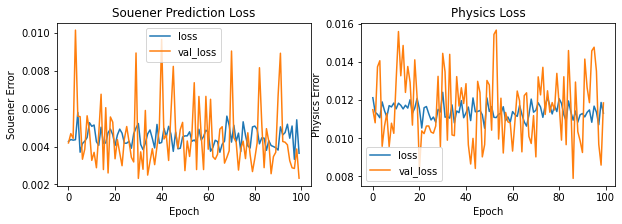

In [89]:
plot_loss_physics_and_regression(history)

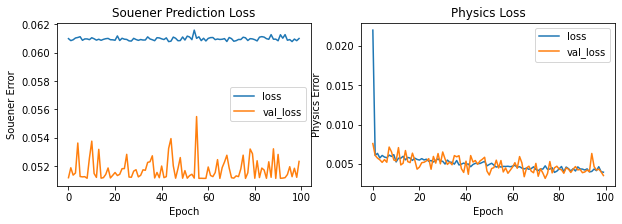

In [103]:
plot_loss_physics_and_regression(history)

In [80]:
predictions = model.predict(dm.X_scaled_test)

normalized_souener_pred = predictions[0]

normalized_zmixpca_pred = predictions[1]

In [134]:
dm.createTrainTestData("ZmixPCA_randomequaltraintestsplit",5, None, None)

In _createTrainTestData Y_test.shape: (8219, 1)
In createTrainTestData Y_test.shape: (8219, 1)


In [117]:
dm.X_scaled_train.shape

(8220, 53)

In [118]:
dm.rom_scaled_train.shape

(8220, 5)

In [128]:
str(dm.Y_train.shape)

'(8220, 1)'

In [120]:
dm.Y_train.shape

(8220, 1)

In [90]:
Y_pred = dm.outputScaler.inverse_transform(normalized_souener_pred)

In [91]:
Y_pred = Y_pred.flatten()

In [92]:
def printError (err):
    TotalAbsoluteError = err[0]

    TotalSquaredError = err[1]

    MeanAbsoluteError = err[2]

    MeanSquaredError = err[3]

    MeanPercentageError = err[4]

    NumPoints = err[5]

    print ('Total Absolute Error: ', TotalAbsoluteError)
    print ('Mean Absolute Error: ', MeanAbsoluteError)
    print ('Mean Percentage Error: ', MeanPercentageError)
    print ('Total Squared Error: ', TotalSquaredError)
    print ('Mean Squared Error: ', MeanSquaredError)
    print ('Number of Points: ', NumPoints)

def computeAndPrintError(Y_pred, Y_test):    
    printError (computeError (Y_pred, Y_test))
    return

def computeError (Y_pred, Y_test):
    evaluation_df_1 = pd.DataFrame()

    evaluation_df_1['souener'] = Y_test.flatten()

    evaluation_df_1['souener_pred'] = Y_pred.flatten()

    evaluation_df_1['souener_pred_L1'] = evaluation_df_1['souener'] - evaluation_df_1['souener_pred'] 

    evaluation_df_1['souener_pred_L2'] = evaluation_df_1['souener_pred_L1'] * evaluation_df_1['souener_pred_L1']

    evaluation_df_1['souener_pred_L1Percent'] = ((evaluation_df_1['souener'] - evaluation_df_1['souener_pred'])/evaluation_df_1['souener']) 

    TotalAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()

    TotalSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()

    MeanAbsoluteError = evaluation_df_1['souener_pred_L1'].abs().sum()/evaluation_df_1['souener_pred_L1'].abs().count()

    MeanSquaredError = evaluation_df_1['souener_pred_L2'].abs().sum()/evaluation_df_1['souener_pred_L2'].abs().count()

    NumPoints = evaluation_df_1['souener_pred_L1Percent'].abs().count()

    MeanPercentageError = evaluation_df_1['souener_pred_L1Percent'].abs().sum()/NumPoints

    return [TotalAbsoluteError,TotalSquaredError,MeanAbsoluteError,MeanSquaredError,MeanPercentageError,NumPoints]

In [93]:
err = computeAndPrintError(Y_pred, dm.Y_test)

Total Absolute Error:  101744239607511.84
Mean Absolute Error:  12379150700.512451
Mean Percentage Error:  817.7356815239557
Total Squared Error:  8.338392053594463e+24
Mean Squared Error:  1.0145263479248646e+21
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

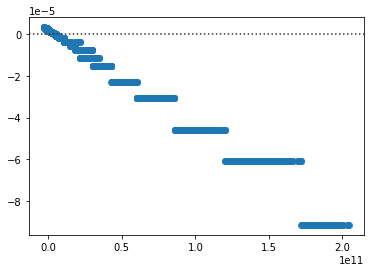

In [94]:

sns.residplot(dm.Y_test, getResiduals(dm.Y_test,Y_pred))

In [69]:
Y_pred

array([1.9969366e+09, 1.9969366e+09, 1.9969366e+09, ..., 1.9969366e+09,
       1.9969366e+09, 1.9969366e+09], dtype=float32)

In [90]:
predictions = model.predict(normalized_species_test)

normalized_souener_pred = predictions[0]

normalized_zmixpca_pred = predictions[1]

In [91]:
Y_pred = scaler_souener.inverse_transform(normalized_souener_pred)

In [92]:
Y_pred = Y_pred.flatten()

In [93]:
err = computeAndPrintError(Y_pred, Y_test)

Total Absolute Error:  4075696778120.0723
Mean Absolute Error:  495887185.56029594
Mean Percentage Error:  11.566193482823351
Total Squared Error:  1.2845184238119073e+22
Mean Squared Error:  1.5628646110377265e+18
Number of Points:  8219


C:\Users\amol\.conda\envs\tensorflow_v2\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

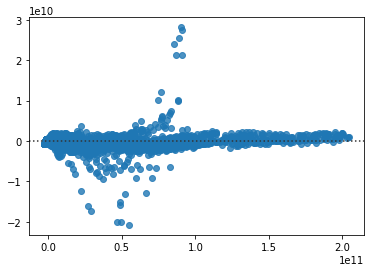

In [94]:
sns.residplot(Y_test.flatten(), getResiduals(Y_test,Y_pred))

In [ ]:
Total Absolute Error:  6563454066133.884
Mean Absolute Error:  798570880.4153649

In [ ]:
Total Absolute Error:  4075696778120.0723
Mean Absolute Error:  495887185.56029594

In [95]:
model.save("pcdnn_paper_1")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: pcdnn_paper_1\assets
